In [1]:
from datasets import list_datasets,load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/workspaces/AI/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
import torchtext
from torchtext.data import get_tokenizer

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the hub")

There are 100416 datasets currently available on the hub


In [21]:
emotions = load_dataset("emotion")
type(emotions)

/workspaces/AI/.venv/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


datasets.dataset_dict.DatasetDict

In [22]:
# Write everything into a csv file 
def write_to_csv(dataset):
    # Create directory if not exist
    try:
        os.mkdir("Datasets/Emotion")
    except FileExistsError:
        pass
    df = pd.DataFrame(dataset)
    df.to_csv("emotion.csv",index=False)
    # Moving file to the right directory
    os.rename("emotion.csv","Datasets/Emotion/emotion.csv")

In [23]:
data = list(emotions["train"])

In [24]:
write_to_csv(data)

In [25]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [26]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["Label Name"] = df["label"].apply(label_int2str)
df.head()

,text,label,Label Name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


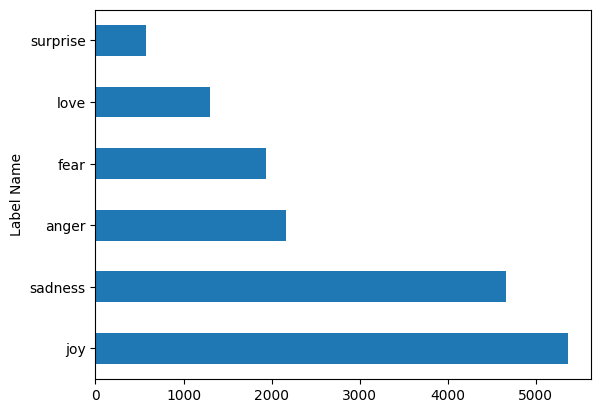

In [27]:
df["Label Name"].value_counts().plot.barh()
plt.show()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

In [29]:
print(f"The len of X_train: {len(X_train)}, X_test: {len(X_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}")
X_test.head(), y_test.head(), X_train.head(), y_train.head()

The len of X_train: 12800, X_test: 3200, y_train: 12800, y_test: 3200


(8756    ive made it through a week i just feel beaten ...
 4660                   i feel this strategy is worthwhile
 6095    i feel so worthless and weak what does he have...
 304                                     i feel clever nov
 8241          im moved in ive been feeling kind of gloomy
 Name: text, dtype: object,
 8756    0
 4660    1
 6095    0
 304     1
 8241    0
 Name: label, dtype: int64,
 676      i refers of course though i cant help feeling ...
 12113    im starting to feel that im suffering from fat...
 7077     i feel like i probably would have liked this b...
 13005                  i didn t really feel awkward at all
 12123    im feeling a little grumpy today with the lame...
 Name: text, dtype: object,
 676      1
 12113    0
 7077     2
 13005    0
 12123    3
 Name: label, dtype: int64)

In [30]:
# Tokenizer the text
Tokenizer = get_tokenizer("basic_english")
X_train, X_test = X_train.apply(Tokenizer), X_test.apply(Tokenizer)

In [31]:
X_train.head(), X_test.head()

(676      [i, refers, of, course, though, i, cant, help,...
 12113    [im, starting, to, feel, that, im, suffering, ...
 7077     [i, feel, like, i, probably, would, have, like...
 13005         [i, didn, t, really, feel, awkward, at, all]
 12123    [im, feeling, a, little, grumpy, today, with, ...
 Name: text, dtype: object,
 8756    [ive, made, it, through, a, week, i, just, fee...
 4660            [i, feel, this, strategy, is, worthwhile]
 6095    [i, feel, so, worthless, and, weak, what, does...
 304                                [i, feel, clever, nov]
 8241    [im, moved, in, ive, been, feeling, kind, of, ...
 Name: text, dtype: object)

In [2]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, num_filters, filter_sizes, dropout_prob):
        super(TextSentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(conv, conv.size(2)).squeeze(2) for conv in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logits = self.fc(x)
        return logits
